<a href="https://colab.research.google.com/github/ajgeglio/ML_For_HealthCare/blob/main/StatisticalML_ForBreastCancerClassification_TonyGeglio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical ML for Breast Cancer Classification
### Tony Geglio
SAT5114

Github Link: https://github.com/ajgeglio/ML_For_HealthCare/upload/main

Requirements:

1. use a k-fold cross-validation and a test dataset. Report the final performance for the test dataset.

2. use gridsearch or randomsearch to tune the hyperparameters in your ML classifier;

3. use GitHub to share your code. Make your GitHub project public.

Options: Teamwork is allowed for this project. However, each team should have at maximum 3 members. Every team member should use a different ML classifier. In your submitted PDF file, please list your team members and your own contribution if you work in a team.

Submission: 1.  one-page PDF file to explain your program, including GitHub code link to your implementation; 2. Screenshot of your results (showing accuracy, sensitivity (precision), and specificity).

Example from: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

Let's first load the required python packages

In [3]:
# model selection and metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split
# Import scikit-learn dataset library
from sklearn import datasets
# keep track of times
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.preprocessing import StandardScaler


Exploring Data

After you have load the dataset from sklearn, you might want to know a little bit more about it. You can check feature and target names.

In [4]:
#Load dataset
cancer = datasets.load_breast_cancer()
# print the names of the 13 features
print("Features: ", cancer.feature_names)

# print the label type of cancer('malignant' 'benign')
print("Labels: ", cancer.target_names)

Features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Labels:  ['malignant' 'benign']


Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Split the dataset by using the function train_test_split(). you need to pass 3 parameters features, target, and test_set size. Additionally, you can use random_state to select records randomly.

In [7]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3,random_state=109) # 70% training and 30% test
i = 0
print(X_train.shape)
pd.DataFrame(X_train)[0:5]

(398, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,14.22,23.12,94.37,609.9,0.10750,0.24130,0.198100,0.06618,0.2384,0.07542,...,15.74,37.18,106.40,762.4,0.15330,0.93270,0.84880,0.17720,0.5166,0.14460
1,11.20,29.37,70.67,386.0,0.07449,0.03558,0.000000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905
2,16.50,18.29,106.60,838.1,0.09686,0.08468,0.058620,0.04835,0.1495,0.05593,...,18.13,25.45,117.20,1009.0,0.13380,0.16790,0.16630,0.09123,0.2394,0.06469
3,12.46,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
4,14.64,15.24,95.77,651.9,0.11320,0.13390,0.099660,0.07064,0.2116,0.06346,...,16.34,18.24,109.40,803.6,0.12770,0.30890,0.26040,0.13970,0.3151,0.08473


The shape method shows us that we have 30 attributes and 398 samples. Also, a quick look at the data indicates that we should standardize the data so that distance based methods can work

In [10]:
scaler = StandardScaler()
if i == 0:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    i+=1
else: pass
pd.DataFrame(X_train)[0:5]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.012286,0.914711,0.086605,-0.138496,0.795843,2.601089,1.367293,0.449164,2.071438,1.814805,...,-0.115479,1.925243,-0.029608,-0.209443,0.932552,4.347375,2.796378,0.962696,3.550718,3.423548
1,-0.838006,2.395669,-0.881154,-0.760920,-1.526226,-1.277537,-1.106860,-1.258767,-2.727653,-1.083879,...,-0.901214,2.113081,-0.954508,-0.762517,-1.690963,-1.242676,-1.300390,-1.738191,-2.108936,-1.359906
2,0.654228,-0.229773,0.586002,0.495882,0.047378,-0.351810,-0.374730,-0.010982,-1.150912,-0.954575,...,0.376120,-0.042029,0.290447,0.213073,0.088770,-0.523286,-0.497736,-0.347661,-0.807216,-1.044551
3,-0.483248,-1.523538,-0.547951,-0.507113,-1.580391,-1.186096,-1.017273,-0.962241,-0.723199,-0.357787,...,-0.639988,-1.566539,-0.715948,-0.600775,-1.616537,-1.180073,-1.219594,-1.329705,-0.986438,-0.731991
4,0.130538,-0.952481,0.143773,-0.021739,1.196806,0.576179,0.137835,0.564264,1.100021,0.115380,...,0.007935,-1.251239,0.059296,-0.138852,-0.175183,0.374679,-0.043559,0.391120,0.382884,0.075969


### Generating SVM Model (example)

Let's build support vector machine model. First, import the SVM module and create support vector classifier object by passing argument kernel as the linear kernel in SVC() function.

Then, fit your model on train set using fit() and perform prediction on the test set using predict().

In [11]:
# Supplied example

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9883040935672515
Precision: 0.9818181818181818
Recall: 1.0


96.49%, is a good accuracy.

For further evaluation, you can also check precision and recall of model. 

We will also use gridsearch parameter tuning and 5-fold cross validation...

## Performance report functions 
### Adapted from ml4covid.py

In [12]:
def calc_specificity(y_actual, y_pred, thresh=0.5):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = metrics.accuracy_score(y_actual, (y_pred > thresh))
    recall = metrics.recall_score(y_actual, (y_pred > thresh))
    precision = metrics.precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f' % auc)
    print('accuracy:%.3f' % accuracy)
    print('recall:%.3f' % recall)
    print('precision:%.3f' % precision)
    print('specificity:%.3f' % specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

def report_performance(clf, X_train, X_test, y_train, y_test, thresh=0.5, clf_name="CLF"):
    print("[x] performance for {} classifier".format(clf_name))
    y_train_preds = clf.predict_proba(X_train)[:, 1]
    y_test_preds = clf.predict_proba(X_test)[:, 1]
    print('Training:')
    train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train, y_train_preds,
                                                                                               thresh)
    print('Test:')
    test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test, y_test_preds, thresh)
    return {"train": {"auc": train_auc, "acc": train_accuracy, "recall": train_recall, "precision": train_precision,
                      "specificity": train_specificity},
            "test": {"auc": test_auc, "acc": test_accuracy, "recall": test_recall, "precision": test_precision,
                     "specificity": test_specificity}}

## SVM Model
### Code adapted from ml4covid19.py
#### Best Model performance

SVC(C=0.1, gamma=0.1, kernel='linear', max_iter=1000000, probability=True)
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}\
[x] performance for SVM classifier\
Training:\
AUC:0.991\
accuracy:0.955\
recall:0.980\
precision:0.949\
specificity:0.913
 
Test:\
AUC:0.997\
accuracy:0.959\
recall:0.972\
precision:0.963\
specificity:0.937

In [25]:
def train_svm(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn import svm
    svc = svm.SVC(probability=True, max_iter=10000)
    warnings.filterwarnings("ignore")
    parameters = {'C': [1e-1, 1, 10, 100],
                  'gamma': [0.1, 0.01],
                  'kernel': ['linear', 'rbf', 'sigmoid']}
    # parameters = {'C': [1],
    #               'gamma': [0.001],
    #               'kernel': ['linear', 'rbf', 'sigmoid']}
    auc_scoring = make_scorer(roc_auc_score)
    if n_split == 1:
        grid_clf = GridSearchCV(estimator=svc, param_grid=parameters, cv=[(slice(None), slice(None))],
                                scoring=auc_scoring, verbose=0)
    else:
        grid_clf = GridSearchCV(estimator=svc, param_grid=parameters, cv=n_split, scoring=auc_scoring, verbose=0)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="SVM")
    return grid_clf.best_estimator_, grid_clf.best_params_, performance_
best_estimator_, best_params_, svm_performance_ = train_svm(X_train, X_test, y_train, y_test, n_split=5)

SVC(C=10, gamma=0.01, max_iter=10000, probability=True)
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
[x] performance for SVM classifier
Training:
AUC:0.998
accuracy:0.987
recall:0.996
precision:0.984
specificity:0.973
 
Test:
AUC:0.998
accuracy:0.982
recall:1.000
precision:0.973
specificity:0.952
 


## Logistic Regression Model
### Code adapted from ml4covid.py
#### Best Model Results
LogisticRegression(C=1000, random_state=42)
{'C': 1000, 'penalty': 'l2'}
[x] performance for LR classifier

Training:\
AUC:0.989\
accuracy:0.950\
recall:0.972\
precision:0.949\
specificity:0.913
 
Test:\
AUC:0.992\
accuracy:0.947\
recall:0.954\
precision:0.963\
specificity:0.937

In [24]:
def train_lr(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42, max_iter = 100000)
    warnings.filterwarnings("ignore")
    parameters = {'C': [1e-2, 1e-1, 1, 10],
                  'penalty': [ "l2", "elasticnet"]}
    auc_scoring = make_scorer(roc_auc_score)
    if n_split == 1:
        grid_clf = GridSearchCV(estimator=lr, param_grid=parameters, cv=[(slice(None), slice(None))],
                                scoring=auc_scoring, verbose=1)
    else:
        grid_clf = GridSearchCV(estimator=lr, param_grid=parameters, cv=n_split, scoring=auc_scoring, verbose=1)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="LR")
    return grid_clf.best_estimator_, grid_clf.best_params_, performance_
best_estimator_, best_params_, lr_performance_ = train_lr(X_train, X_test, y_train, y_test, n_split=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
LogisticRegression(C=0.1, max_iter=100000, random_state=42)
{'C': 0.1, 'penalty': 'l2'}
[x] performance for LR classifier
Training:
AUC:0.995
accuracy:0.980
recall:0.992
precision:0.976
specificity:0.960
 
Test:
AUC:0.999
accuracy:0.982
recall:1.000
precision:0.973
specificity:0.952
 


## Decision Tree Classifier
### Code adapted from ml4covid19.py
#### Best Model Results
DecisionTreeClassifier(max_depth=17, min_samples_split=5)
{'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 5}
[x] performance for DecisionTree classifier\
Training:\
AUC:1.000\
accuracy:1.000\
recall:1.000\
precision:1.000\
specificity:1.000
 
Test:\
AUC:0.954\
accuracy:0.959\
recall:0.972\
precision:0.963\
specificity:0.937

In [23]:
def train_decision_tree(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn.tree import DecisionTreeClassifier
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5)
    parameters = {"criterion": ["gini", "entropy"],
                  "max_depth": [10, 12, 15,17,20],
                  "min_samples_split": [5, 10, 15]}

    auc_scoring = make_scorer(roc_auc_score)
    if n_split == 1:
        grid_clf = GridSearchCV(estimator=dtree, param_grid=parameters, cv=[(slice(None), slice(None))],
                                scoring=auc_scoring, verbose=0)
    else:
        grid_clf = GridSearchCV(estimator=dtree, param_grid=parameters, cv=n_split, scoring=auc_scoring, verbose=0)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="DecisionTree")
    return grid_clf.best_estimator_, grid_clf.best_params_, performance_
best_estimator_, best_params_, dt_performance_ = train_decision_tree(X_train, X_test, y_train, y_test, n_split=5)

DecisionTreeClassifier(max_depth=20, min_samples_split=5)
{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
[x] performance for DecisionTree classifier
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
 
Test:
AUC:0.951
accuracy:0.959
recall:0.981
precision:0.955
specificity:0.921
 


### Gradient Boosting
#### Adapted ml4covid19
No success on data

In [ ]:
# def train_gradient_boosting(X_train, X_test, y_train, y_test, n_split=5):
#     from sklearn.ensemble import GradientBoostingClassifier
#     gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

#     n_estimators = range(5, 100, 5)
#     max_depth = range(1, 10, 1)
#     learning_rate = [0.001, 0.01, 0.1]
#     random_grid_gbc = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

#     auc_scoring = make_scorer(roc_auc_score)
#     grid_clf = GridSearchCV(estimator=gbc, param_grid=random_grid_gbc, cv=n_split, scoring=auc_scoring, verbose=0)
#     grid_clf.fit(X_train, y_train)

#     print(grid_clf.best_estimator_)
#     print(grid_clf.best_params_)
#     gb_performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="Gradient Boosting")
#     return grid_clf.best_estimator_, grid_clf.best_params_, gb_performance_
# best_estimator_, best_params_, gb_performance_ = train_gradient_boosting(X_train, X_test, y_train, y_test, n_split=5)

## Gaussian NB classifier
### Adapted from ml4covid19.py
#### Best model results

GaussianNB()\
{'priors': None}\
[x] performance for GaussianNB classifier\
Training:\
AUC:0.987\
accuracy:0.942\
recall:0.976\
precision:0.935\
specificity:0.886
 
Test:\
AUC:0.994\
accuracy:0.953\
recall:0.981\
precision:0.946\
specificity:0.905

In [22]:
def train_bayesian(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn.naive_bayes import GaussianNB
    bayes = GaussianNB()
    parameters = {"priors": [None, [np.count_nonzero(y_train==0)/y_train.shape[0],y_train.sum()/y_train.shape[0]]]}
    auc_scoring = make_scorer(roc_auc_score)
    if n_split == 1:
        grid_clf = GridSearchCV(estimator=bayes, param_grid=parameters, cv=[(slice(None), slice(None))],
                                scoring=auc_scoring, verbose=0)
    else:
        grid_clf = GridSearchCV(estimator=bayes, param_grid=parameters, cv=n_split, scoring=auc_scoring, verbose=0)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    nb_performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="GaussianNB")
    return grid_clf.best_estimator_, grid_clf.best_params_, nb_performance_

best_estimator_, best_params_, nb_performance_ = train_bayesian(X_train, X_test, y_train, y_test, n_split=5)


GaussianNB()
{'priors': None}
[x] performance for GaussianNB classifier
Training:
AUC:0.986
accuracy:0.930
recall:0.956
precision:0.933
specificity:0.886
 
Test:
AUC:0.992
accuracy:0.936
recall:0.954
precision:0.945
specificity:0.905
 


## Random Forest Classifier
### Code adapted from ml4covid19.py
#### Best Model Results

RandomForestClassifier(max_depth=4, max_features='auto', min_samples_split=4,
                       n_estimators=10, random_state=42)
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 10}
[x] performance for RF classifier\
Training:\
AUC:0.998\
accuracy:0.982\
recall:0.996\
precision:0.976\
specificity:0.960\
 
Test:\
AUC:0.993\
accuracy:0.959\
recall:1.000\
precision:0.939\
specificity:0.889\

In [21]:
def train_rf(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(max_depth=6, random_state=42)
    rf.fit(X_train, y_train)

    n_estimators = (1,3,5,10,15)
    max_features = ['sqrt']
    max_depth = range(1, 5, 1)
    min_samples_split = range(2, 6, 2)
    criterion = ['gini', 'entropy']
    parameters = {'n_estimators': n_estimators, 'max_features': max_features,
                  'max_depth': max_depth, 'min_samples_split': min_samples_split, 'criterion': criterion}
    auc_scoring = make_scorer(roc_auc_score)
    if n_split == 1:
        grid_clf = GridSearchCV(estimator=rf, param_grid=parameters, cv=[(slice(None), slice(None))],
                                scoring=auc_scoring, verbose=0, n_jobs=-1)
    else:
        grid_clf = GridSearchCV(estimator=rf, param_grid=parameters, cv=n_split, scoring=auc_scoring, verbose=0,
                                n_jobs=-1)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, clf_name="RF")
    return grid_clf.best_estimator_, grid_clf.best_params_, performance_

best_estimator_, best_params_, rf_performance_ = train_rf(X_train, X_test, y_train, y_test, n_split=5)

RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_split=4,
                       n_estimators=10, random_state=42)
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 10}
[x] performance for RF classifier
Training:
AUC:0.998
accuracy:0.982
recall:0.996
precision:0.976
specificity:0.960
 
Test:
AUC:0.993
accuracy:0.959
recall:1.000
precision:0.939
specificity:0.889
 


## Multi-Layer Perceptron Classifier
### Code Adapted from ml4covid19.py
#### Best Model Results

MLPClassifier(alpha=1, hidden_layer_sizes=(40, 20))
{'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (40, 20)}\
[x] performance for MLP classifier\
Training:\
AUC:0.968\
accuracy:0.930\
recall:0.980\
precision:0.914\
specificity:0.846
 
Test:\
AUC:0.983\
accuracy:0.947\
recall:0.963\
precision:0.954\
specificity:0.921

In [16]:
def train_mlp(X_train, X_test, y_train, y_test, n_split=5):
    from sklearn.neural_network import MLPClassifier
    warnings.filterwarnings("ignore")
    mlp = MLPClassifier(max_iter=500)

    activation = ['identity', 'logistic', 'tanh', 'relu']
    hidden_layer_sizes = [(10, 5), (20, 10), (40, 20), (40,), (20,), (10,)]
    alpha = [0.01, 0.1, 1, 10]
    parameters = {'activation': activation, 
                  'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alpha}
    auc_scoring = make_scorer(roc_auc_score)
    grid_clf = GridSearchCV(estimator=mlp, param_grid=parameters, cv=n_split, 
                            scoring=auc_scoring, verbose=0, n_jobs=-1)
    grid_clf.fit(X_train, y_train)

    print(grid_clf.best_estimator_)
    print(grid_clf.best_params_)
    performance_ = report_performance(grid_clf.best_estimator_, X_train, X_test, 
                                      y_train, y_test, clf_name="MLP")
    return grid_clf.best_estimator_, grid_clf.best_params_, performance_
best_estimator_, best_params_, mlp_performance_ = train_mlp(X_train, X_test, y_train, y_test, n_split=5)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(20, 10), max_iter=500)
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (20, 10)}
[x] performance for MLP classifier
Training:
AUC:1.000
accuracy:0.997
recall:1.000
precision:0.996
specificity:0.993
 
Test:
AUC:0.997
accuracy:0.982
recall:1.000
precision:0.973
specificity:0.952
 


## Plotting the Performance summary of the models

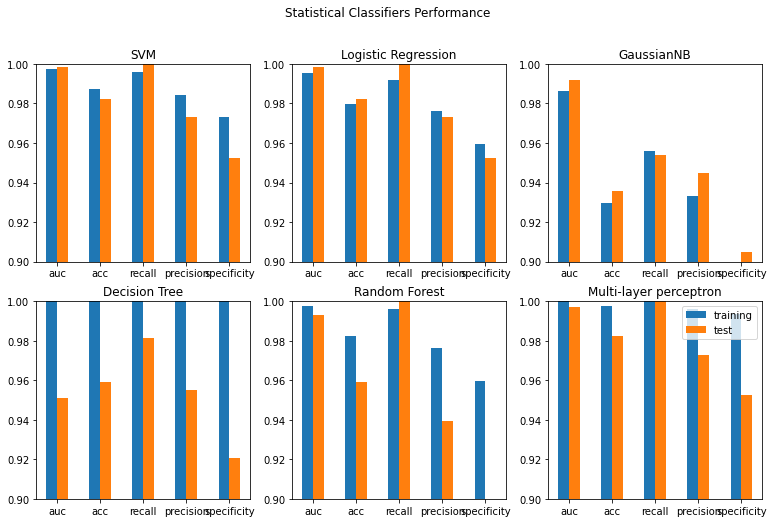

In [30]:
# print(svm_performance_['train'])
performances = [svm_performance_,lr_performance_, nb_performance_, 
                dt_performance_, rf_performance_, mlp_performance_]
models = ["SVM", "Logistic Regression","GaussianNB", "Decision Tree", 
          "Random Forest", "Multi-layer perceptron"]
fig, ax = plt.subplots(2,3, figsize = (13,8), tight_layout=False)
i=0
for r in range(2):
    for c in range(3):
        ax[r][c].bar(height = performances[i]['train'].values(), 
                     x = list(performances[i]['train'].keys()),
                     width = -0.25,
                     align = 'edge',
                     label = "training"
                
                     )
        ax[r][c].bar(height = performances[i]['test'].values(), 
                     x = list(performances[i]['test'].keys()),
                     width = 0.25,
                     align = 'edge',
                     label = "test"
                     )
        ax[r][c].set_ylim(0.9,1)
        ax[r][c].set_title(f"{models[i]}")
        i+=1
plt.suptitle('Statistical Classifiers Performance')
plt.legend()
plt.show()

### Performance Summary
The Figure above shows that SVM, followed by logistic regression, then MLP performed the best overall when considering the 5 different metrics on classifying the breast cancer data set. Specificity was generally lower meaning that we see a higher rate of false positives. Recall, however is very high meaning we have very few False negatives which may be important in healthcare. Models were optimized on AUC. Many models were able to perform well so a data scientist may also consider other factors such as speed and algorithmic efficiency of the model for use in the real world.

In [ ]:
# import scipy
# a = [1,2,3]
# scipy.stats.zscore(a, axis=0, ddof=0, nan_policy='propagate')
# a = pd.DataFrame(a)
# # np.std(a)
# a.std(ddof=0)